# Download and unzip images

In [1]:
!wget https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
!tar -zxf mnist_png.tar.gz

--2020-01-03 00:08:46--  https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz [following]
--2020-01-03 00:08:46--  https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.52.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz.1’

mnist_png.tar.gz.1  100%[===================>]  14.96M  --.-KB/s    in 0.1s    

2020-01-03 00:08:46 (135 MB/s) - ‘mnist_png.tar.gz.1’ saved [15683414/15683414]



In [2]:
!tree -Lh 3

.
├── [2.8M]  mnist1.ipynb
├── [ 17K]  mnist1-onnx.ipynb
├── [4.6M]  mnist_cnn.onnx
├── [4.6M]  mnist_cnn.pt
├── [4.0K]  mnist_png
│   ├── [4.0K]  testing
│   │   ├── [ 24K]  0
│   │   ├── [ 36K]  1
│   │   ├── [ 28K]  2
│   │   ├── [ 28K]  3
│   │   ├── [ 24K]  4
│   │   ├── [ 20K]  5
│   │   ├── [ 20K]  6
│   │   ├── [ 32K]  7
│   │   ├── [ 24K]  8
│   │   └── [ 32K]  9
│   └── [4.0K]  training
│       ├── [156K]  0
│       ├── [188K]  1
│       ├── [152K]  2
│       ├── [148K]  3
│       ├── [152K]  4
│       ├── [132K]  5
│       ├── [136K]  6
│       ├── [156K]  7
│       ├── [140K]  8
│       └── [160K]  9
├── [ 15M]  mnist_png.tar.gz
├── [ 15M]  mnist_png.tar.gz.1
├── [ 21K]  mnist_tensorboard.ipynb
├── [  25]  requirements.txt
├── [2.4K]  udemy_course.ipynb
└── [2.3K]  Untitled1.ipynb

23 directories, 10 files


In [22]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.onnx
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('runs')

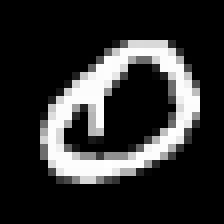

In [4]:
image0 = Image.open('mnist_png/training/0/11105.png')
image0 = image0.resize((image0.width*8, image0.height*8))
image0

In [5]:
def data_loader(data_type, batch_size):
    data_path = 'mnist_png/'+ data_type + '/'  # data_type = training/testing
    
#    By default the image has 3 channels and we exepect the image to be grayscale.
#    So let's tranform the image to grayscale

    dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        #    By default the imageFolder loads images with 3 channels and we expect the image to be grayscale.
        #    So let's transform the image to grayscale
        transform =  transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
    )
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        shuffle=True
    )
    return loader

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
#         super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)        
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128) # 64(no. of channels from conv2)*12*12 = 9216
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):        
        #x.shape = 32, 1, 28, 28 (N=batch size, C=channels, H=height, W=width) . original image is 28x28 px
        x = self.conv1(x) 
        #x.shape = 32, 32, 26, 26
        x = F.relu(x)        
        x = self.conv2(x) 
        # x.shape = 32, 64, 24, 24
        x = F.max_pool2d(x, 2) # stride=2 will reduce the dimensions to half
        # x.shape = 32, 64, 12, 12
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        # x.shape = 32, 9216 (64*12*12)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
def test(model, device, test_loader):
    model.eval() # instructing pytorch that we want to evaluate (and not train)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [31]:
losses = []

def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train() # instructing pytorch that we want to train
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        if(batch_idx+ 1 == len(train_loader)): 
            losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [32]:
def main():
    device = torch.device("cuda")
    
    batch_size = 32
    train_loader = data_loader('training', batch_size )
    test_loader = data_loader('testing', batch_size )
    log_interval=600 # batches
    lr = 1.0
    epochs = 5
    gamma = 0.7
    
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    
    losses=[]
    
    for epoch in range(1, epochs + 1):
        train(log_interval, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()
    
    torch.save(model.state_dict(), "mnist_cnn.pt")


In [33]:
import time
if __name__ == '__main__':
    start_time = time.time()
    print('starting at: ',time.strftime('%Y-%m-%d %H:%M:%S'))
    main()
    end_time = time.time()
    print('ending  at: ',time.strftime('%Y-%m-%d %H:%M:%S'))
    print('total time taken: ', round(end_time-start_time,2), ' seconds')
    

starting at:  2020-01-03 00:20:01
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300301
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.231497
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.045461
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.046399

Test set: Average loss: 0.0516, Accuracy: 9852/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.414771
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.142006
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.013728
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.003862

Test set: Average loss: 0.0368, Accuracy: 9890/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.005111
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.018242
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.071781
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.077556

Test set: Average loss: 0.0367, Accuracy: 9882/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.004783
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.012498
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.010993
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.026821

Te

ValueError: x and y must have same first dimension, but have shapes (4,) and (5,)

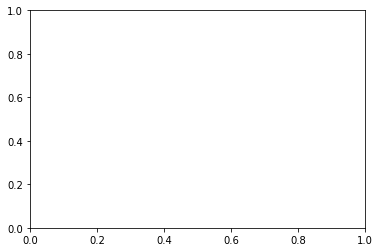

In [34]:
plt.plot(range(1,5),losses)

In [30]:
x = range(1,5)
x

range(1, 5)

Time taken for 5 epochs with num_workers=1, pin_memory=True :  108.68  seconds

 
Time taken for 5 epochs without setting num_workers and pin_memory: 117.45  seconds



In [11]:
import numpy as np
from PIL import Image
import torch

In [12]:
image0 = Image.open('mnist_png/training/0/11105.png') .convert('L')
transform =  transforms.Compose([transforms.ToTensor()])
image0_tensor = transform(image0)
image0_tensor_unsqueezed = image0_tensor.unsqueeze(0)

In [13]:
model_inference = Net()
state_dict = torch.load('mnist_cnn.pt')

In [14]:
model_inference.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [15]:
model_inference(image0_tensor_unsqueezed)

tensor([[-2.2292e-05, -1.6549e+01, -1.2810e+01, -1.8207e+01, -2.3879e+01,
         -1.6727e+01, -1.0848e+01, -1.9417e+01, -2.0303e+01, -1.7363e+01]],
       grad_fn=<LogSoftmaxBackward>)

In [16]:
model_inference

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
train_loader = data_loader('training', 32 )

In [18]:
len(train_loader.dataset.classes)

10